# Compress convolutional layers
We test VGG classifier.
First init some basic environment.

In [2]:
!pwd

/notebook/Matrix_tensor_shad/prod/Seminar2


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# VGG16 classifier

In [4]:
import sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchnet as tnt
from torchnet.engine import Engine
from torchnet.logger import VisdomLogger, VisdomPlotLogger
from data_loader import CIFAR10Data


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def plot_history(history):
    """
    plot loss and acc history.
    :param history: train returned history object
    """
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('acc value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history['train_lr'])
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()


def train_loop(model, opt, epoch, loss_fn=F.cross_entropy, lr_scheduler=None):
    """
    train model and test on test data
    :return:
    """
    num_classes = 10

    data = CIFAR10Data(train_split=0.8)
    train_itr = data.get_train_loader(batch_size=64)
    val_itr = data.get_val_loader(batch_size=64)

    meter_loss = tnt.meter.AverageValueMeter()
    classacc = tnt.meter.ClassErrorMeter(accuracy=True)
    confusion_meter = tnt.meter.ConfusionMeter(num_classes, normalized=True)
    history = {'train_loss': [], 'train_acc': [], 'train_lr': [], 'val_loss': [], 'val_acc': []}

    port = 8097
    env = 'CIFAR10'
    
    torch.manual_seed(6666)
    torch.cuda.manual_seed(6666)
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    model.to(device)

    def reset_meters():
        classacc.reset()
        meter_loss.reset()

    def h(sample):
        x = sample[0].to(device)
        y = sample[1].to(device)
        o = model(x)
        return loss_fn(o, y), o

    def on_forward(state):
        classacc.add(state['output'].detach(), state['sample'][1])
        meter_loss.add(state['loss'].item())
        confusion_meter.add(state['output'].detach(), state['sample'][1])
        if state['train']:
            state['iterator'].set_postfix_str(s="loss:{:.4f}, acc:{:.4f}%".format(meter_loss.value()[0], classacc.value()[0]))

    def on_start_epoch(state):
        current_lr = opt.param_groups[0]['lr']
        print('Epoch: %d/%d, lr:%.2e' % (state['epoch']+1, state['maxepoch'], current_lr))
        reset_meters()
        model.train(True)
        state['iterator'] = tqdm(state['iterator'], file=sys.stdout)
        history['train_lr'].append(current_lr)

    def on_end_epoch(state):
        # print('Training loss: %.4f, accuracy: %.2f%%' % (meter_loss.value()[0], classerr.value()[0]))
        history['train_loss'].append(meter_loss.value()[0])
        history['train_acc'].append(classacc.value()[0])

        # do validation at the end of each epoch
        reset_meters()
        model.train(False)
        engine.test(h, val_itr)
        print('Val loss: %.4f, accuracy: %.2f%%' % (meter_loss.value()[0], classacc.value()[0]))

        if lr_scheduler:
            if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_scheduler.step(classacc.value()[0], epoch=(epoch+1))
            else:
                lr_scheduler.step()

        history['val_loss'].append(meter_loss.value()[0])
        history['val_acc'].append(classacc.value()[0])

    engine = Engine()
    engine.hooks['on_forward'] = on_forward
    engine.hooks['on_start_epoch'] = on_start_epoch
    engine.hooks['on_end_epoch'] = on_end_epoch
    engine.train(h, train_itr, epoch, opt)

    # test
    test_itr = data.get_test_loader(batch_size=64)
    model.train(False)
    engine.test(h, test_itr)
    print('Test loss: %.4f, accuracy: %.2f%%' % (meter_loss.value()[0], classacc.value()[0]))
    return history

In [5]:
import torch.optim as optim
import torch.nn as nn
from cifar10.tnt_solver import *
from cifar10.classifiers.vgg import VGG11

model = VGG11()
print(model);

_VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ker

# pre-train VGG

In [9]:
%%time
%%hide output
import time
opt = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4, nesterov=True)
loss_fn = F.cross_entropy
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5)



# lr_scheduler = None
#start = timeit.timeit()
s = time.time()

history = train_loop(model, opt, epoch=20, loss_fn=loss_fn, lr_scheduler=lr_scheduler)
curr_time = (time.time()-s )*1000
#end = timeit.timeit()
print (curr_time)
;

UsageError: Cell magic `%%hide` not found.


In [25]:
torch.save(model, 'pretrain_model_11')

# plot loss history
We check the classifier by plotting the loss and acc.

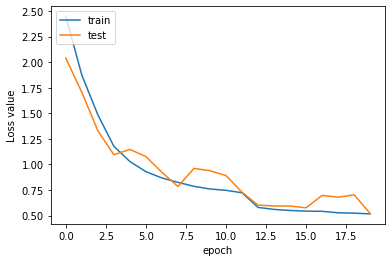

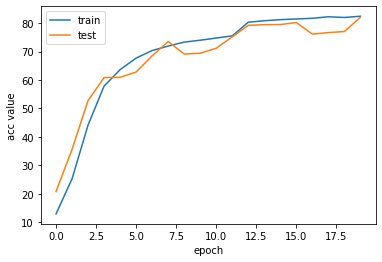

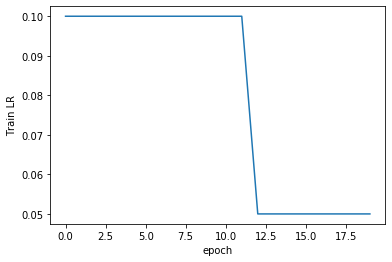

In [26]:
plot_history(history)

# Define compression

In [100]:
import tensorly
import numpy as np
from tensorly.decomposition import tucker, partial_tucker, parafac

def cp_decomposition_conv_layer(layer, rank):
    """ Gets a conv layer and a target rank, 
        returns a nn.Sequential object with the decomposition """

    # Perform CP decomposition on the layer weight tensorly.
    
    print("Data shape", layer.weight.data.shape, " Estimated rank", rank)
    
    weight, factors = parafac(layer.weight.data, rank=rank, init='svd')
    print (len(factors))
    last, first, vertical, horizontal = factors
        #parafac(layer.weight.data, rank=rank, init='svd')

    pointwise_s_to_r_layer = torch.nn.Conv2d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1, stride=1, padding=0, 
            dilation=layer.dilation, bias=False)

    depthwise_vertical_layer = torch.nn.Conv2d(in_channels=vertical.shape[1], 
            out_channels=vertical.shape[1], kernel_size=(vertical.shape[0], 1),
            stride=1, padding=(layer.padding[0], 0), dilation=layer.dilation,
            groups=vertical.shape[1], bias=False)

    depthwise_horizontal_layer = \
        torch.nn.Conv2d(in_channels=horizontal.shape[1], \
            out_channels=horizontal.shape[1], 
            kernel_size=(1, horizontal.shape[0]), stride=layer.stride,
            padding=(0, layer.padding[0]), 
            dilation=layer.dilation, groups=horizontal.shape[1], bias=False)

    pointwise_r_to_t_layer = torch.nn.Conv2d(in_channels=last.shape[1], \
            out_channels=last.shape[0], kernel_size=1, stride=1,
            padding=0, dilation=layer.dilation, bias=True)

    pointwise_r_to_t_layer.bias.data = layer.bias.data

    depthwise_horizontal_layer.weight.data = \
        torch.transpose(horizontal, 1, 0).unsqueeze(1).unsqueeze(1)
    depthwise_vertical_layer.weight.data = \
        torch.transpose(vertical, 1, 0).unsqueeze(1).unsqueeze(-1)
    pointwise_s_to_r_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    pointwise_r_to_t_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)

    new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer, \
                    depthwise_horizontal_layer, pointwise_r_to_t_layer]
    
    return nn.Sequential(*new_layers)

In [33]:
def tucker_decomposition_conv_layer(layer, ranks):
    """ Gets a conv layer, 
        returns a nn.Sequential object with the Tucker decomposition.
        The ranks are estimated with a Python implementation of VBMF
        https://github.com/CasvandenBogaard/VBMF
    """

    
    print(layer, "VBMF Estimated ranks", ranks)
    print (layer.weight.data.shape)
    core, [last, first] = \
        partial_tucker(layer.weight.data, \
            modes=[0,1], ranks=ranks, init='svd')
    
    print ("first", first.shape[0], first.shape[1])
    print ("second", last.shape)
    print ("third", core.shape)

    # A pointwise convolution that reduces the channels from S to R3
    first_layer = torch.nn.Conv2d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1,
            stride=1, padding=0, dilation=layer.dilation, bias=False)
    print ("first_layer.weight.data.shape", first_layer.weight.data.shape)

    # A regular 2D convolution layer with R3 input channels 
    # and R3 output channels
    core_layer = torch.nn.Conv2d(in_channels=core.shape[1], \
            out_channels=core.shape[0], kernel_size=layer.kernel_size,
            stride=layer.stride, padding=layer.padding, dilation=layer.dilation,
            bias=False)
    print ("core_layer.weight.data.shape", core_layer.weight.data.shape)

    # A pointwise convolution that increases the channels from R4 to T
    last_layer = torch.nn.Conv2d(in_channels=last.shape[1], \
        out_channels=last.shape[0], kernel_size=1, stride=1,
        padding=0, dilation=layer.dilation, bias=True)
    print ("last_layer.weight.data.shape" ,last_layer.weight.data.shape)

    last_layer.bias.data = layer.bias.data

    first_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    last_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)
    core_layer.weight.data = core
    
    print ("first_layer.weight.data.shape", first_layer.weight.data.shape)

    new_layers = [first_layer, core_layer, last_layer]
    return nn.Sequential(*new_layers)


In [34]:
x = torch.randn(16, 128, 1, 1)
print (x.shape)

x = torch.transpose(x, 0, 1)
print (x.shape)

torch.Size([16, 128, 1, 1])
torch.Size([128, 16, 1, 1])


In [67]:
model = torch.load('pretrain_model_11')

In [68]:
print (model)

_VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ker

# Apply Tucker compression to first 4 convolution layers

In [75]:
import tensorly as tl
tl.set_backend('pytorch')

cp = True
N = len(model.layers._modules.keys())
for i, key in enumerate(model.layers._modules.keys()):
    print(i)
    if ( i > 10 ):
        print ("continue")
        continue
    if i >= N - 2:
        break
    if isinstance(model.layers._modules[key], torch.nn.modules.conv.Conv2d):
        conv_layer = model.layers._modules[key]
        ranks = [max(conv_layer.weight.data.cpu().numpy().shape[0]//4, 10), max(conv_layer.weight.data.cpu().numpy().shape[1]//4, 10)]
        if not cp:
            rank = max(conv_layer.weight.data.cpu().numpy().shape)//4
            decomposed = cp_decomposition_conv_layer(conv_layer, rank)
        else:
            decomposed = tucker_decomposition_conv_layer(conv_layer, ranks = ranks)

        model.layers._modules[key] = decomposed

0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [16, 10]
torch.Size([64, 3, 3, 3])
first 3 3
second torch.Size([64, 16])
third torch.Size([16, 3, 3, 3])
first_layer.weight.data.shape torch.Size([3, 3, 1, 1])
core_layer.weight.data.shape torch.Size([16, 3, 3, 3])
last_layer.weight.data.shape torch.Size([64, 16, 1, 1])
first_layer.weight.data.shape torch.Size([3, 3, 1, 1])
1
2
3
4
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [32, 16]
torch.Size([128, 64, 3, 3])
first 64 16
second torch.Size([128, 32])
third torch.Size([32, 16, 3, 3])
first_layer.weight.data.shape torch.Size([16, 64, 1, 1])
core_layer.weight.data.shape torch.Size([32, 16, 3, 3])
last_layer.weight.data.shape torch.Size([128, 32, 1, 1])
first_layer.weight.data.shape torch.Size([16, 64, 1, 1])
5
6
7
8
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) VBMF Estimated ranks [64, 32]
torch.Size([256, 128, 3, 3])
first 128 32
seco

In [70]:
torch.save(model, 'decompose_model_11')

# Compare regular model and model with decomposed convolutional layers

In [76]:
s = time.time()
opt = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4, nesterov=True)
history = train_loop(model, opt, epoch=10, loss_fn=loss_fn, lr_scheduler=lr_scheduler)
curr_time = (time.time() - s )*1000
#end = timeit.timeit()
print (curr_time)
;

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 69.03it/s, loss:0.3263, acc:88.7925%]
Val loss: 0.4762, accuracy: 84.37%
Epoch: 2/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 67.38it/s, loss:0.2898, acc:89.8800%]
Val loss: 0.5383, accuracy: 83.39%
Epoch: 3/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 66.22it/s, loss:0.2716, acc:90.5475%]
Val loss: 0.4514, accuracy: 85.29%
Epoch: 4/10, lr:1.00e-02
100%|██████████| 625/625 [00:08<00:00, 69.78it/s, loss:0.2633, acc:90.8300%]
Val loss: 0.5124, accuracy: 83.45%
Epoch: 5/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 66.63it/s, loss:0.2472, acc:91.4425%]
Val loss: 0.4306, accuracy: 86.04%
Epoch: 6/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 69.34it/s, loss:0.2422, acc:91.4550%]
Val loss: 0.4145, accuracy: 86.63%
Epoch: 7/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 

''

In [77]:
print(model);

_VGG(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): Conv2d(128, 32, kernel_size=(1, 1), s

In [78]:
model = torch.load('pretrain_model_11')

In [79]:
s = time.time()
opt = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4, nesterov=True)

history = train_loop(model, opt, epoch=10, loss_fn=loss_fn, lr_scheduler=lr_scheduler)
curr_time = (time.time() - s )*1000
#end = timeit.timeit()
print (curr_time)
;

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 65.34it/s, loss:0.3338, acc:88.5750%]
Val loss: 0.3772, accuracy: 87.17%
Epoch: 2/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 67.93it/s, loss:0.2863, acc:90.2875%]
Val loss: 0.3528, accuracy: 88.05%
Epoch: 3/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 67.45it/s, loss:0.2613, acc:90.9575%]
Val loss: 0.3661, accuracy: 87.63%
Epoch: 4/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 67.88it/s, loss:0.2497, acc:91.4850%]
Val loss: 0.3724, accuracy: 87.31%
Epoch: 5/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 67.52it/s, loss:0.2390, acc:91.7325%]
Val loss: 0.3678, accuracy: 87.54%
Epoch: 6/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 68.25it/s, loss:0.2261, acc:92.0425%]
Val loss: 0.3743, accuracy: 87.61%
Epoch: 7/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 

''

In [80]:
print(model);

_VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ker

# The same for CP decomposition.

In [102]:
model = torch.load('pretrain_model_11')

In [103]:
import tensorly as tl
tl.set_backend('pytorch')

cp = False
N = len(model.layers._modules.keys())
for i, key in enumerate(model.layers._modules.keys()):
    print(i)
    if ( i > 14 or i < 4):
        print ("continue")
        continue
    if i >= N - 2:
        break
    if isinstance(model.layers._modules[key], torch.nn.modules.conv.Conv2d):
        conv_layer = model.layers._modules[key]
        ranks = [max(conv_layer.weight.data.cpu().numpy().shape[0]//4, 10), max(conv_layer.weight.data.cpu().numpy().shape[1]//4, 10)]
        if not cp:
            rank = max(conv_layer.weight.data.cpu().numpy().shape[0]//4, conv_layer.weight.data.cpu().numpy().shape[1]//4)
            decomposed = cp_decomposition_conv_layer(conv_layer, rank)
        else:
            decomposed = tucker_decomposition_conv_layer(conv_layer, ranks = ranks)

        model.layers._modules[key] = decomposed

0
continue
1
continue
2
continue
3
continue
4
Data shape torch.Size([128, 64, 3, 3])  Estimated rank 32
4
5
6
7
8
Data shape torch.Size([256, 128, 3, 3])  Estimated rank 64
4
9
10
11
Data shape torch.Size([256, 256, 3, 3])  Estimated rank 64
4
12
13
14
15
continue
16
continue
17
continue
18
continue
19
continue
20
continue
21
continue
22
continue
23
continue
24
continue
25
continue
26
continue
27
continue
28
continue


In [104]:
torch.save(model, 'decompose_model_cp')

In [105]:
print (model)

_VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), groups=32, bias=False)
      (2): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), groups=32, bias=False)
      (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(64, 64, kernel_siz

In [106]:
s = time.time()
opt = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4, nesterov=True)
history = train_loop(model, opt, epoch=10, loss_fn=loss_fn, lr_scheduler=lr_scheduler)
curr_time = (time.time() - s )*1000
#end = timeit.timeit()
print (curr_time)
;

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/10, lr:1.00e-02
100%|██████████| 625/625 [00:10<00:00, 60.36it/s, loss:0.7993, acc:72.6425%]
Val loss: 0.7503, accuracy: 74.47%
Epoch: 2/10, lr:1.00e-02
100%|██████████| 625/625 [00:10<00:00, 61.52it/s, loss:0.5687, acc:80.4350%]
Val loss: 0.5577, accuracy: 80.81%
Epoch: 3/10, lr:1.00e-02
100%|██████████| 625/625 [00:10<00:00, 61.92it/s, loss:0.5073, acc:82.4150%]
Val loss: 0.5553, accuracy: 80.95%
Epoch: 4/10, lr:1.00e-02
100%|██████████| 625/625 [00:10<00:00, 58.22it/s, loss:0.4745, acc:83.4975%]
Val loss: 0.5557, accuracy: 81.10%
Epoch: 5/10, lr:1.00e-02
100%|██████████| 625/625 [00:10<00:00, 61.53it/s, loss:0.4426, acc:84.7875%]
Val loss: 0.5773, accuracy: 80.29%
Epoch: 6/10, lr:1.00e-02
100%|██████████| 625/625 [00:10<00:00, 61.64it/s, loss:0.4217, acc:85.5600%]
Val loss: 0.4952, accuracy: 83.38%
Epoch: 7/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 

''

In [107]:
model = torch.load('pretrain_model_11')

In [108]:
s = time.time()
opt = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4, nesterov=True)
history = train_loop(model, opt, epoch=10, loss_fn=loss_fn, lr_scheduler=lr_scheduler)
curr_time = (time.time() - s )*1000
#end = timeit.timeit()
print (curr_time)
;

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 63.48it/s, loss:0.3338, acc:88.5750%]
Val loss: 0.3772, accuracy: 87.17%
Epoch: 2/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 65.88it/s, loss:0.2863, acc:90.2875%]
Val loss: 0.3528, accuracy: 88.05%
Epoch: 3/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 66.55it/s, loss:0.2613, acc:90.9575%]
Val loss: 0.3661, accuracy: 87.63%
Epoch: 4/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 66.03it/s, loss:0.2497, acc:91.4850%]
Val loss: 0.3724, accuracy: 87.31%
Epoch: 5/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 67.33it/s, loss:0.2390, acc:91.7325%]
Val loss: 0.3678, accuracy: 87.54%
Epoch: 6/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 65.71it/s, loss:0.2261, acc:92.0425%]
Val loss: 0.3743, accuracy: 87.61%
Epoch: 7/10, lr:1.00e-02
100%|██████████| 625/625 [00:09<00:00, 

''